# Predict Complaint Types

The goal of this exercise is to do Model Development and Validation to find the answer to the Question 4 of the problem statement:

> Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

This exercise will be based on the findings of the previous three exercises. Therefore, we shall use the 311 complaints and the PLUTO data sets to feature-engineer a 'HEAT/HOT WATER' complaints for tax lots dataset. The latter is to be used to build a predictive model to estimate the number of future complaints based on selected house characteristics (which we will also refer to as properties or features).

We shall formalize the question at hand as follows:

> Build a prediction model for the number of 'HEAT/HOT WATER' complaints per year for a house with a selectd set of characteristics.

The rest of the work will be organized as follows, we shall:
1. Load, clean and prepare the data sets
   * In a similar way we did for answering Questions 1 to 3
2. Join the '311 complaint' data set with the PLUTO one
   * In a similar way we did for answering Questions 1 to 3
3. Determine the models to be used
   * This will influence the feature selection process
4. Perform house feature selection
   * This will be re-done as we used a different model for Question 3
5. Perform model training
   * Including parameter tuning and cross validation if any
6. Evaluate and compare models
7. Recommending the best performing model

Please note that, the data sets will not be described as the latter has already been done when answering Questions 1 to 3. We shall only repeat that the PLUTO data set will initially be taked with the following set of features:

In [2]:
pluto_features = ['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR',
              'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth',
              'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
              'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1',
              'ZipCode', 'YCoord', 'XCoord']
print('The initial set of PLUTO features to consider:\n', pluto_features)

The initial set of PLUTO features to consider:
 ['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1', 'ZipCode', 'YCoord', 'XCoord']


# 1. Load, clean, prepare

Loading of the data can be done both from the IBM cloud storage and the locally present CSV files. The latter is decided upon the presence of the proper secure field values of the credentials:

In [150]:
import os
import re
import seaborn
import warnings
import ibm_boto3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from botocore.client import Config

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

from sklearn.linear_model import Ridge

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

%matplotlib inline

In [4]:
# @hidden_cell
SECURITY_DUMMY = '----------------'
erm2_nwe9_creds = {
    'IAM_SERVICE_ID'    : SECURITY_DUMMY,
    'IBM_API_KEY_ID'    : SECURITY_DUMMY,
    'ENDPOINT'          : 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT' : 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET'            : SECURITY_DUMMY,
    'FILE'              : 'erm2_nwe9.csv'
}
bk_18v1_creds = {
    'IAM_SERVICE_ID'    : SECURITY_DUMMY,
    'IBM_API_KEY_ID'    : SECURITY_DUMMY,
    'ENDPOINT'          : 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT' : 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET'            : SECURITY_DUMMY,
    'FILE'              : 'BK_18v1.csv'
}
bx_18v1_creds = {
    'IAM_SERVICE_ID'    : SECURITY_DUMMY,
    'IBM_API_KEY_ID'    : SECURITY_DUMMY,
    'ENDPOINT'          : 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT' : 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET'            : SECURITY_DUMMY,
    'FILE'              : 'BX_18v1.csv'
}
mn_18v1_creds = {
    'IAM_SERVICE_ID'    : SECURITY_DUMMY,
    'IBM_API_KEY_ID'    : SECURITY_DUMMY,
    'ENDPOINT'          : 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT' : 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET'            : SECURITY_DUMMY,
    'FILE'              : 'MN_18v1.csv'
}
qn_18v1_creds = {
    'IAM_SERVICE_ID'    : SECURITY_DUMMY,
    'IBM_API_KEY_ID'    : SECURITY_DUMMY,
    'ENDPOINT'          : 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT' : 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET'            : SECURITY_DUMMY,
    'FILE'              : 'QN_18v1.csv'
}
si_18v1_creds = {
    'IAM_SERVICE_ID'    : SECURITY_DUMMY,
    'IBM_API_KEY_ID'    : SECURITY_DUMMY,
    'ENDPOINT'          : 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT' : 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET'            : SECURITY_DUMMY,
    'FILE'              : 'SI_18v1.csv'
}

pluto_creds = [bk_18v1_creds, bx_18v1_creds, mn_18v1_creds, qn_18v1_creds, si_18v1_creds]

In [5]:
# Allows to get the data source for the credentials from the IBM cloud or local csv file 
def get_data_source(credentials) :
    '''Creates a data source from the IBM cloud or local csv file according to the credentials'''
    # Here we check if the credentials are present, if not try 
    # load the local file if they are then read from the cloud.
    if credentials.get('IAM_SERVICE_ID') == SECURITY_DUMMY :
        # This is the alternative to get the code run locally with a local csv file
        body = 'data' + os.path.sep + credentials.get('FILE')
    else :
        client = ibm_boto3.client(
            service_name = 's3',
            ibm_api_key_id = credentials.get('IBM_API_KEY_ID'),
            ibm_auth_endpoint = credentials.get('IBM_AUTH_ENDPOINT'),
            config = Config(signature_version='oauth'),
            endpoint_url = credentials.get('ENDPOINT'))

        body = client.get_object(
            Bucket = credentials.get('BUCKET'),
            Key = credentials.get('FILE'))['Body']

        # add missing __iter__ method, so pandas accepts body as file-like object
        def __iter__(self): return 0
        if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

    return body

Further, we shall subsequently load the 311 and PLUTO data sets. Along the way, we will select the necessary columns and check on (, and correct if needed,) the column data types.

## 311 complaints

Balow we load the data set, and then first select the required complaints along with the needed columns:

In [6]:
# Get the data source for the credentials
dhp_ds = get_data_source(erm2_nwe9_creds)

# Read the CSV file
dhp_df = pd.read_csv(dhp_ds, parse_dates = ['created_date', 'closed_date'])
print('Number of all complaints:', dhp_df.shape[0])

Number of all complaints: 6034470


In [7]:
# Select the 'HEAT/HOT WATER' complaints
dhp_df = dhp_df[(dhp_df['complaint_type'] == 'HEAT/HOT WATER')]
print('Number of \'HEAT/HOT WATER\' complaints is:', dhp_df.shape[0])

Number of 'HEAT/HOT WATER' complaints is: 2159103


In [8]:
# Select the columns that matter, and rename for convenience
dhp_df = dhp_df[['created_date', 'incident_address', 'incident_zip']]
dhp_df = dhp_df.rename({'incident_address':'Address', 'incident_zip':'ZipCode'}, axis=1)

In [9]:
# Convert the address to upper case for uniformity
dhp_df.Address = dhp_df.Address.map(str).map(str.upper)
# Strip the address strings
dhp_df.Address = dhp_df.Address.str.strip()
# Replace sequence of white spaces with one
dhp_df.Address = dhp_df.Address.str.replace('\s+',' ')

In [10]:
# Drop the Na/NaN valued rows
init_size = dhp_df.shape[0]
dhp_df.dropna(inplace = True)
print('Number of rows before dropping Na/NaN:', init_size,', after:', dhp_df.shape[0])

Number of rows before dropping Na/NaN: 2159103 , after: 2140078


Exract the year the complaint was created and then drop the *'created_date'* column.

In [11]:
dhp_df['Year'] = dhp_df.created_date.dt.year
dhp_df.drop(columns = ['created_date'], inplace = True)

Let us summarize the Year statitics so far:

In [12]:
year_descr = dhp_df['Year'].describe().astype(int)
year_descr

count    2140078
mean        2014
std            2
min         2010
25%         2012
50%         2015
75%         2017
max         2020
Name: Year, dtype: int64

As one can see the min/max years range is between `2010` and `2020` which means that there were no missing/wrong *'created_date'* values present.

We will only need the average complaint counts per year for each given *'Address'*/*'ZipCode'* pair:

In [13]:
# Group by the zip code and address to count the complaints
dhp_df = dhp_df.groupby(['ZipCode', 'Address']).size().to_frame()

# Rename the counts column and then compute the average count for the min/max years range
dhp_df.rename({0 : 'AvgCnt'}, axis = 1, inplace = True)
dhp_df.AvgCnt = dhp_df.AvgCnt/(year_descr.loc['max'] - year_descr.loc['min'] + 1)

# Re-set the indexes to turn the Address and ZipCode back into columns
dhp_df.reset_index(level = 1, inplace = True)
dhp_df.reset_index(level = 0, inplace = True)
dhp_df.head()

,ZipCode,Address,AvgCnt
0,10001.0,10 WEST 28 STREET,1.454545
1,10001.0,100 WEST 26 STREET,0.090909
2,10001.0,102 WEST 29 STREET,0.727273
3,10001.0,103 WEST 27 STREET,0.181818
4,10001.0,11 WEST 34 STREET,0.090909


Finally, we check on the column types:

In [14]:
dhp_df.dtypes

ZipCode    float64
Address     object
AvgCnt     float64
dtype: object

All the data types are in order: the address is a string and the zip code and average complaint count are floats.

## PLUTO 

Let us load and combine all of the PLUTO csv files first:

In [15]:
# Iterate to load all the PLUTO csv files and
# re-combine them into a single data frame
pluto_df = pd.DataFrame()
for cred in pluto_creds :
    # Get the data source for the credentials
    ds = get_data_source(cred)
    # Read and append the CSV file
    pluto_df = pluto_df.append(pd.read_csv(ds, low_memory = False))

Perform initial pre-processing such as, selecting the right rows, dropping the Na/NaN valued rows, pre-processing the *'Address'* column values to match those of the '311 complaints' data set

In [16]:
num_pluto_rows = pluto_df.shape[0]

# Select the recommended columns
pluto_df = pluto_df[pluto_features]

# Drop the Na/NaN valued rows
pluto_df = pluto_df.dropna()

# Convert the address to upper case for uniformity
pluto_df.Address = pluto_df.Address.map(str).map(str.upper)
# Strip the address strings
pluto_df.Address = pluto_df.Address.str.strip()
# Replace sequence of white spaces with one
pluto_df.Address = pluto_df.Address.str.replace('\s+',' ')

print('The number of PLUTO rows before:', num_pluto_rows, ', after:', pluto_df.shape[0])

The number of PLUTO rows before: 859212 , after: 835242


As we know from aanswering Question 3, there are Address column values in the PLUTO data set that do not contain house numbers. As, before, let us drop entries those right away:

In [17]:
num_pluto_rows = pluto_df.shape[0]

# Create the pattern for selecting a proper address with one house
# number followed by a white space and then an alpha numeric street
# name which can contain multiple words separated by white spaces
regex_pat = re.compile(r'^\d+(\s+\w+)+')

# Then we only select the addresses that have a house number in it
pluto_df = pluto_df[pluto_df.Address.str.match(regex_pat)]

print('The number of PLUTO rows before:', num_pluto_rows, ', after:', pluto_df.shape[0])

The number of PLUTO rows before: 835242 , after: 522280


Next, the same as done for Question 3, we shall remove the entries with the duplicate *'Address'*/*'Zipcode'* pairs:

In [18]:
num_pluto_rows = pluto_df.shape[0]

# First count the distinct ZipCode-Address groups
occur_cnt = pluto_df.groupby(['ZipCode','Address']).size().to_frame()
occur_cnt.reset_index(level=0, inplace = True)
occur_cnt.reset_index(level=0, inplace = True)

# Rename the counts column
occur_cnt.rename(columns={0:'Count'}, inplace = True)

# Join the data into the original table
pluto_df_tmp = pd.merge(pluto_df, occur_cnt, left_on=['ZipCode','Address'], right_on=['ZipCode','Address'])

# Only keep the Address - ZipCode pairs that occur once
rows_index = pluto_df_tmp[pluto_df_tmp['Count'] > 1].index
pluto_df = pluto_df_tmp.drop(rows_index, axis = 0)

# Drop the counts columns is it will not be needed and remove the temporary object
pluto_df = pluto_df.drop('Count', axis = 1)
pluto_df_tmp = []

print('The number of PLUTO rows before:', num_pluto_rows, ', after:', pluto_df.shape[0])

The number of PLUTO rows before: 522280 , after: 520137


Finally, let us check on the column data types, as we see there is no unexpected types here:

In [19]:
pluto_df.dtypes

Address        object
BldgArea        int64
BldgDepth     float64
BuiltFAR      float64
CommFAR       float64
FacilFAR      float64
Lot             int64
LotArea         int64
LotDepth      float64
NumBldgs        int64
NumFloors     float64
OfficeArea      int64
ResArea         int64
ResidFAR      float64
RetailArea      int64
YearBuilt       int64
YearAlter1      int64
ZipCode       float64
YCoord        float64
XCoord        float64
dtype: object

# 2. Join data sets

In this section we shall join the cleaned 311 and PLUTO data sets to form a single data frame, we shall do it by performing an inner joint on the 311 and PLUTO data frames. The goint will be done by *'Address'* and *'ZipCode'* columns. This way we will only get the complaints that are marched with the PLUTO tax lot. This approach solves the three yet unresolved issues with the PLUTO data set mentioned in the previous section by ignoring the complaints that could not be matched with the tax lots because of the missing house numbers.

In [20]:
num_311_rows = dhp_df.shape[0]

dhp_pluto_df = pd.merge(dhp_df, pluto_df, how='inner', left_on=['ZipCode','Address'], right_on=['ZipCode','Address'])

print('The number of 311 rows before:', num_311_rows, ', after:', dhp_pluto_df.shape[0])

The number of 311 rows before: 126902 , after: 82937


As one can see the inner joint has reduced our data quite significantly, i.e. by about `100 - (82937 * 100) / 126902 = 34.64`%. However, this is the price we have to pay unless we do a more thorough pre-porocessing of the PLUTO data set. 

Please note that, the number of house properties (features) that is selected is currently rather large:

In [21]:
NUM_FEATURES = (dhp_pluto_df.shape[1] - len(['Lot', 'Address', 'ZipCode', 'AvgCnt']))
print('The number of selected features is:', NUM_FEATURES)

The number of selected features is: 17


We do not consider *'Lot'*, *'Address'*, *'ZipCode'*, and *'AvgCnt'* as the former two were used to join the 311 and PLUTO data sets and are not directly related to house properties. The latter is the target variable, i.e. the one that shall depend on the house properties.

It does not seem that the *'Lot'*, *'Address'* and *'ZipCode'* columns will be needed so let us drop them:

In [22]:
dhp_pluto_df.drop(columns = ['Lot', 'Address', 'ZipCode'], inplace = True)
display(dhp_pluto_df.head())

,AvgCnt,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,YCoord,XCoord
0,1.454545,9763,98.0,3.95,10.0,10.0,2469,98.75,1,5.0,0,4875,0.0,4888,1930,1979,210644.0,987501.0
1,0.727273,8970,82.0,4.16,10.0,10.0,2156,98.75,1,5.0,0,0,10.0,1790,1920,1989,211297.0,986855.0
2,0.181818,4796,76.0,2.88,10.0,10.0,1668,83.42,1,4.0,0,3276,10.0,1520,1920,1989,210983.0,986664.0
3,0.090909,17153,120.0,5.42,15.0,15.0,3162,126.50,1,6.0,1877,0,10.0,7765,1920,0,212224.0,988263.0
4,0.545455,20422,96.0,4.83,10.0,10.0,4229,98.75,2,7.0,0,12866,0.0,4834,1920,2005,211262.0,986709.0


In [23]:
# Store the feature names in an array
FEATURE_NAMES = dhp_pluto_df.columns[range(1, NUM_FEATURES + 1)].to_list()
print('The considered featues are:', FEATURE_NAMES)

The considered featues are: ['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1', 'YCoord', 'XCoord']


Finally, let us double-check that there are no Na/NaN values present in the resulting joint data frame:

In [24]:
dhp_pluto_df.isna().describe()

,AvgCnt,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,YCoord,XCoord
count,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937


According to the table above there are no Na/NaN values present so we can proceed with building models to predict the number of 'HEAT/HOT WATER' comlaints per year based on house properties.

Let us now notice that the values for the numer of floors do not seem to be well alligned:

In [25]:
dhp_pluto_df.NumFloors.unique()

array([ 5.  ,  4.  ,  6.  ,  7.  , 39.  , 11.  , 13.  , 12.  , 10.  ,
       26.  ,  3.  ,  9.  , 18.  , 16.  , 21.  , 17.  ,  0.  , 14.  ,
       15.  , 22.  ,  1.  ,  8.  , 23.  , 33.  ,  4.5 , 34.  , 41.  ,
       20.  ,  2.  , 42.  , 48.  , 19.  ,  2.5 ,  3.5 , 27.  , 32.  ,
       25.  , 24.  , 31.  , 50.  , 38.  , 45.  , 29.  , 47.  , 37.  ,
       66.  , 36.  , 54.  , 56.  , 58.  , 44.  ,  6.5 ,  5.5 , 13.5 ,
       60.  , 11.5 ,  4.75, 30.  ,  7.5 , 20.5 , 52.  , 28.  , 35.  ,
       57.  , 43.  , 23.5 , 78.  , 62.  , 40.  , 49.  , 35.5 , 18.5 ,
        9.5 , 51.  , 22.5 , 15.5 ,  3.75, 16.5 , 12.5 ,  5.09, 14.5 ,
       10.5 ,  2.75,  1.5 , 59.  , 46.  , 76.  ,  1.67,  1.75,  2.67,
        2.25,  3.33,  4.25,  4.33,  3.25,  6.25,  1.25])

Let us round the values up to 0.5:

In [26]:
def round_0_5(x):
    return np.around(x / 0.5, decimals = 0)*0.5
    
dhp_pluto_df.NumFloors = dhp_pluto_df.NumFloors.apply(round_0_5)

Now use the Z-Score to remove the outliers for all the rows.

In [27]:
# Only keep the values within the 3 standard deviations from the mean
num_joint_rows = dhp_pluto_df.shape[0]
dhp_pluto_df = dhp_pluto_df[(np.abs(stats.zscore(dhp_pluto_df)) <= 3).all(axis=1)]
print('The number of rows before:', num_joint_rows, ', after:', dhp_pluto_df.shape[0])

The number of rows before: 82937 , after: 74363


We use the 3 standard deviations filter for the outliers, and the data set size gets reduced by `100 - (74363 * 100) / 82937 = 10.33`%. Let us now notice that the number of unique complaint counts is quite large whereas the complaint counts range is not:

In [28]:
print('The bumber of unique complaint counts is:', len(dhp_pluto_df.AvgCnt.unique()))
dhp_pluto_df.AvgCnt.describe()

The bumber of unique complaint counts is: 285


count    74363.000000
mean         1.363953
std          2.954517
min          0.090909
25%          0.090909
50%          0.272727
75%          1.090909
max         26.000000
Name: AvgCnt, dtype: float64

## 2.1 Summarizing remarks

The number of unique zip/code pairs with average \'HEAT/HOT WATER\' complaint counts was:

In [29]:
print(dhp_df.shape[0])

126902


The number of entries after joining with PLUTO and data cleaning is:

In [30]:
print(dhp_pluto_df.shape[0])

74363


This indicates a significant (`100 - (100 * 74363) / 126902 = 41.40` %) but necessary data loss. Some of it could have been avoided by e.g. using a third party data set to unpack the PLUTO property adresses. However this was considered as not part of this test assignment. Further, let us note that as expected all the columns have numeric values, both the predictor and the target variable columns:

In [31]:
dhp_pluto_df.dtypes

AvgCnt        float64
BldgArea        int64
BldgDepth     float64
BuiltFAR      float64
CommFAR       float64
FacilFAR      float64
LotArea         int64
LotDepth      float64
NumBldgs        int64
NumFloors     float64
OfficeArea      int64
ResArea         int64
ResidFAR      float64
RetailArea      int64
YearBuilt       int64
YearAlter1      int64
YCoord        float64
XCoord        float64
dtype: object

This differs from the approach taken for answerin Question 3, in that there we made a classification prediction system for complaint types per address. Here, instead, we want to estimate the average number of 'HEAT/HOT WATER' complaints per address per year, depending on the hous properties.

Given that the `AvgCnt` range is `[0,26]` and that the decimal number of complaints does not have much of a meaning, there is two possible ways to proceed, i.e. to consider the average number of complaint per year as:

1. A continuous value -- is subject to a regression model
2. A a discrete value -- is subject to a classification model

Before one of the approaches can be used, let us further analyze the data at hand.

# 3. Model and feature selection

In this section we shall start with an assumption we are going to build a predictor model for a continuous target variable `AvgCnt`. Because there is `17` predictor columns available we shall choose a subset of best scoring predictors.

Unlike it was done when answering Question 3 we will take a multi-step approach here in order to:

1. Make a model-independent choice of the predictor columns assuming we have a continuous target variable.
2. We use data visualization in order to asses the best passing model type for the selected predictors.
3. We argue whether we shall switch to the discrete valued target variable, i.e. turn to classificators.
4. Make a final choice for the model to be used and perhaps re-do the feature selection analysis for the model type.

## 3.1 Initial feature selection

There are two ways known to us at the moment to do model-indeprenden feature selection which we will apply here:

1. **Correlation Matrix Analysis**
2. **Univariate Feature Selection**

We shall use both of the methods independently to identify the top 5 features for each of them and then we will compare the obtained results and make a single list of the initially suggested features.

### 3.1.1 Correlation Matrix Analysis

Correlation states how the features are related to each other and/or the target variable. Since we have already removed the outliers, we can use the Pearson correlation. Note that we have separately checked that, using unbiased Spearman correlation for this data will not change the result.

Let us build the correlation matrix and visualize it user a heatmap:

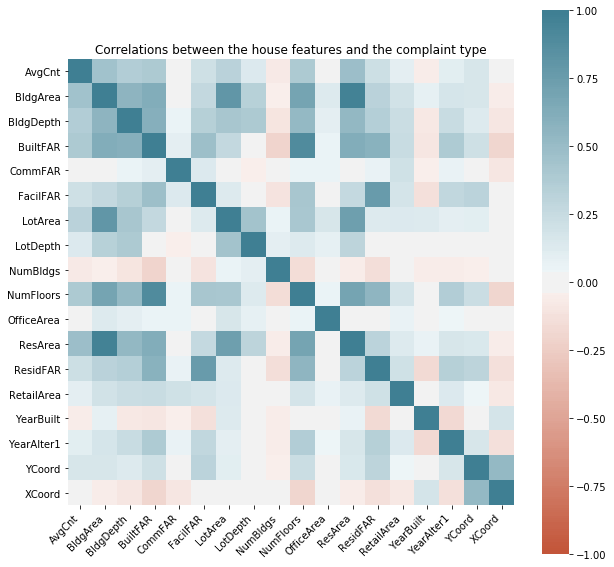

In [32]:
dhp_pluto_corr_df = dhp_pluto_df.corr(method='pearson')

plt.figure(figsize=(10,10))
plt.title('Correlations between the house features and the complaint type')
ax = sns.heatmap(
    dhp_pluto_corr_df, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

As one can see there is a number of strongly correlated features. This means that if we select features that are highly correlated, we shall use Ridge Regression which is a technique used when the data suffers from multicollinearity (i.e. independent variables are highly correlated). This will also be addressed in the final feature selection part of this section.

The correlation values for the *'AvgCnt'* with respect to the features are as follows:

In [33]:
display(dhp_pluto_corr_df['AvgCnt'].sort_values(ascending = False))

AvgCnt        1.000000
ResArea       0.483179
BldgArea      0.459780
BuiltFAR      0.395624
NumFloors     0.392212
BldgDepth     0.365059
LotArea       0.326279
ResidFAR      0.222377
FacilFAR      0.211774
YCoord        0.169503
LotDepth      0.134261
YearAlter1    0.108037
RetailArea    0.092790
XCoord        0.031289
OfficeArea   -0.009207
CommFAR      -0.017789
YearBuilt    -0.047636
NumBldgs     -0.075799
Name: AvgCnt, dtype: float64

Let us compute the absolute correlation values for features and the *'AvgCnt'*:

In [34]:
NUM_COLS = dhp_pluto_corr_df.shape[1]
corr_scores_df = dhp_pluto_corr_df['AvgCnt'].abs().sort_values(ascending=False)[1:NUM_COLS].to_frame()
corr_scores_df.rename({'AvgCode' : 'abs_corr'}, axis = 1, inplace = True)
corr_scores_df.head()

,AvgCnt
ResArea,0.483179
BldgArea,0.459780
BuiltFAR,0.395624
NumFloors,0.392212
BldgDepth,0.365059


The top 5 correlated features with the target variable are:

In [35]:
corr_top_5 = corr_scores_df.index[0:5].to_list()
corr_top_5

['ResArea', 'BldgArea', 'BuiltFAR', 'NumFloors', 'BldgDepth']

### 3.1.2 Univariate Feature Selection

Here we shall consider the `SelectKBest` and `f_regression` from the `sklearn.feature_selection` package. We use `f_regression` as it is suitable for the continuous type target variables. Moreover, it is based on linear regression models and correlation analysis. Let us now compute the top 5 scoring features:

In [36]:
# Create the selector
selector = SelectKBest(f_regression, k = 'all')
# Train on the train set
selector.fit(dhp_pluto_df[FEATURE_NAMES].values, dhp_pluto_df['AvgCnt'].values)

SelectKBest(k='all', score_func=<function f_regression at 0x12dba5ca0>)

In [37]:
# Create the score results data frame 
us_scores_df = pd.DataFrame({ 'feature' : FEATURE_NAMES,
                              'score'   : selector.scores_,
                              'pvalue' : selector.pvalues_})
us_scores_df = us_scores_df.set_index('feature')
us_scores_df.sort_values(by = 'score', ascending = False, inplace = True)
display(us_scores_df.head())

,score,pvalue
feature,,
ResArea,22647.936147,0.0
BldgArea,19933.633355,0.0
BuiltFAR,13798.619608,0.0
NumFloors,13518.509182,0.0
BldgDepth,11433.671128,0.0


 Let us also plot the score values, mind the logarithmic scale:

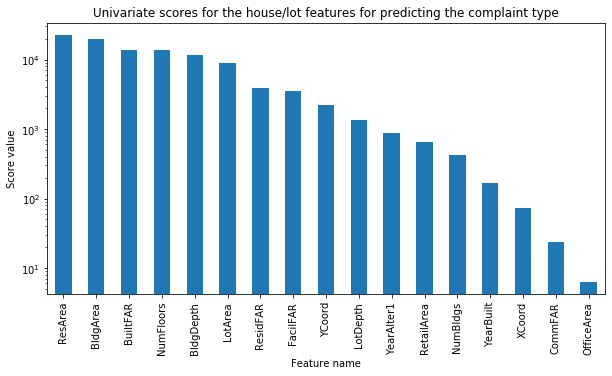

In [38]:
us_scores_df['score'].plot(kind='bar', figsize=(10,5), logy = True)
plt.title('Univariate scores for the house/lot features for predicting the complaint type')
plt.ylabel('Score value')
plt.xlabel('Feature name')
plt.show()
plt.close()

 Let us also plot the score p-values, mind the logarithmic scale:

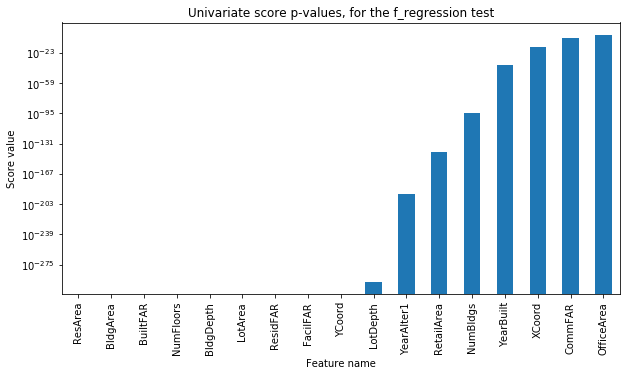

In [39]:
us_scores_df['pvalue'].plot(kind='bar', figsize=(10,5), logy = True)
plt.title('Univariate score p-values, for the f_regression test')
plt.ylabel('Score value')
plt.xlabel('Feature name')
plt.show()
plt.close()

As one can see all the p-values are way below `0.01` so the scores are significant, the top 5 scoring features are:

In [40]:
us_top_5 = us_scores_df.index[0:5].to_list()
display(us_top_5)

['ResArea', 'BldgArea', 'BuiltFAR', 'NumFloors', 'BldgDepth']

### 3.1.3 Initial feature choice

As one can see both methods suggest using the exact same list of features:

In [41]:
common_features = set(us_top_5) & set(corr_top_5)

print('Correlation analysis suggests:', corr_top_5)
print('Univariate analysis suggests:', us_top_5)
print('---\nThe common set of features:', common_features)

# Remember the ordered list of features
initial_top_5 = us_top_5

Correlation analysis suggests: ['ResArea', 'BldgArea', 'BuiltFAR', 'NumFloors', 'BldgDepth']
Univariate analysis suggests: ['ResArea', 'BldgArea', 'BuiltFAR', 'NumFloors', 'BldgDepth']
---
The common set of features: {'ResArea', 'BldgDepth', 'BuiltFAR', 'NumFloors', 'BldgArea'}


## 3.2 Data visualization

Given the five top scoring features to predict the `AvgCnt` value let us visualize each of them:

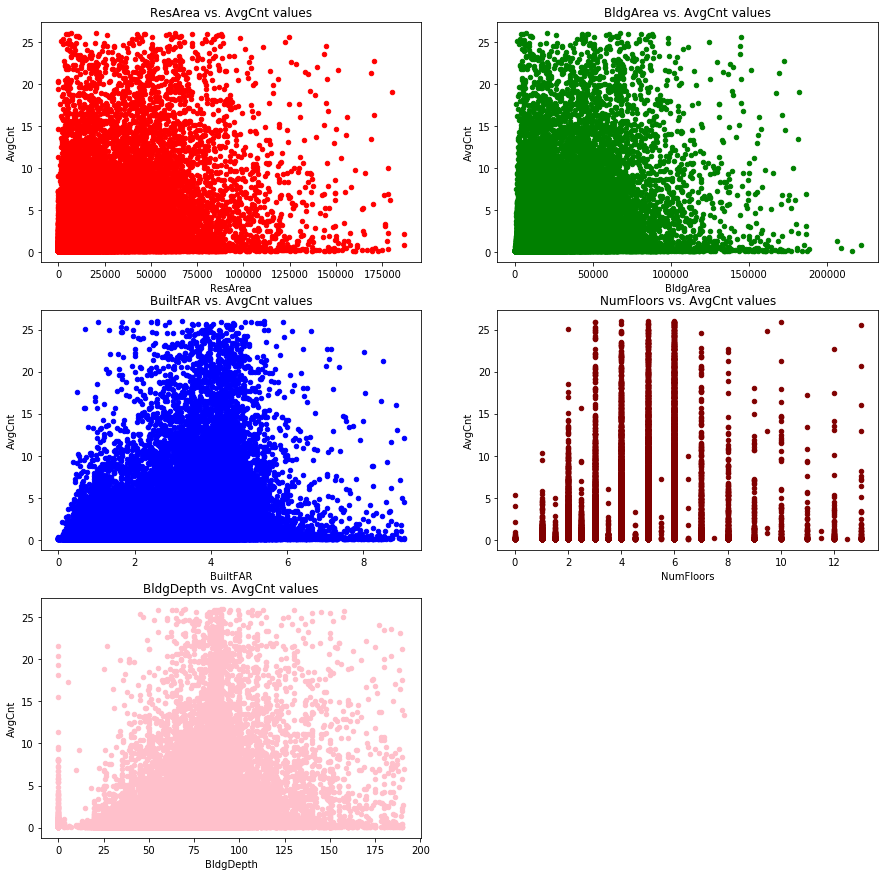

In [42]:
def scatter_plot_feature(fig, idx, feature, color = 'b'):
    ax = fig.add_subplot(3, 2, idx)
    dhp_pluto_df.plot(kind='scatter', x = feature, y = 'AvgCnt', ax = ax, color = color)
    plt.title(feature + ' vs. AvgCnt values')
    plt.xlabel(feature)
    plt.ylabel('AvgCnt')

fig = plt.figure(figsize=(15, 15))
scatter_plot_feature(fig, 1, 'ResArea', 'red')
scatter_plot_feature(fig, 2, 'BldgArea', 'green')
scatter_plot_feature(fig, 3, 'BuiltFAR', 'blue')
scatter_plot_feature(fig, 4, 'NumFloors', 'maroon')
scatter_plot_feature(fig, 5, 'BldgDepth', 'pink')
plt.show()
plt.close()

As one can see there are some clear dependencies between the selected features and the target variable. However, one can see that the `AvgCnt` values for the same type of feature can be distributed pretty broadly, to the extent that they would not be easily captured by a multi-variate linear regression model.

Consider for example the dependency of the average complaint count per year from the number of building floors, first the boxplot an then the mean values:

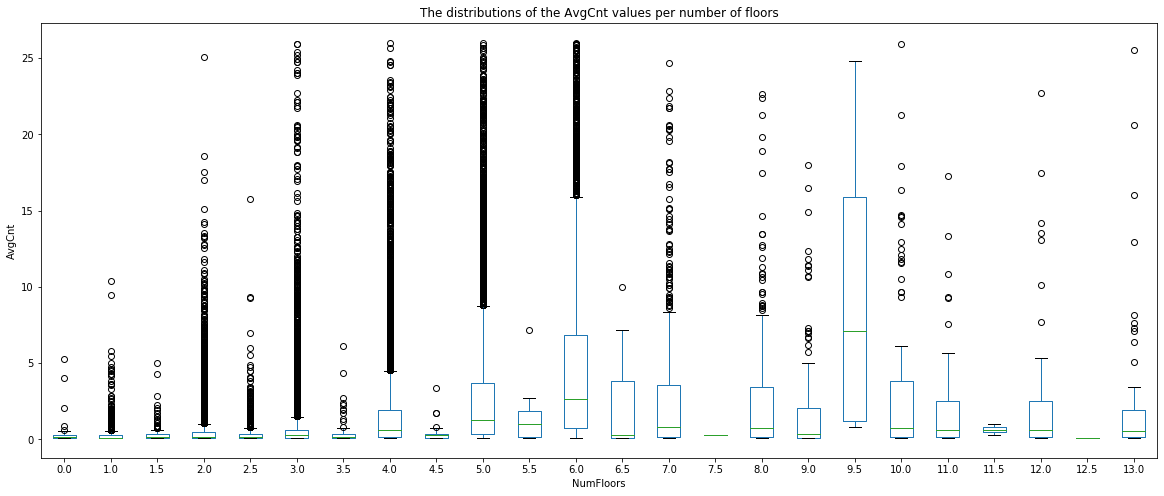

In [43]:
# The box plot for the average counts per number of floors
floors_df = pd.pivot(dhp_pluto_df, columns = 'NumFloors', values = 'AvgCnt')
floors_df.plot(kind='box', figsize = (20,8))
plt.title('The distributions of the AvgCnt values per number of floors')
plt.xlabel('NumFloors')
plt.ylabel('AvgCnt')
plt.show()
plt.close()

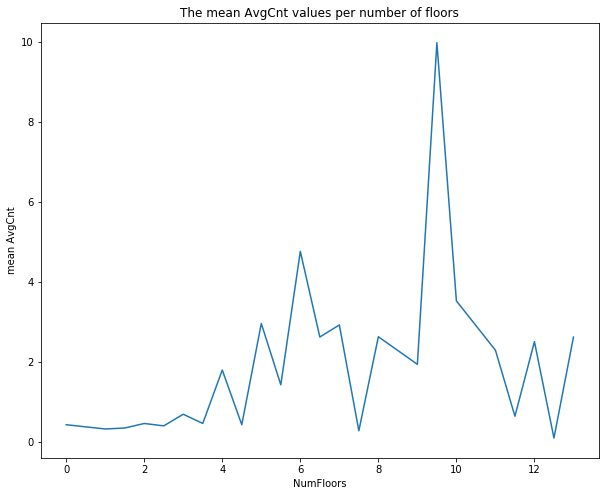

In [44]:
# The line plot for the mean average counts per number of floors
floors_df.mean().plot(figsize = (10,8))
plt.title('The mean AvgCnt values per number of floors')
plt.xlabel('NumFloors')
plt.ylabel('mean AvgCnt')
plt.show()
plt.close()

If we would choose the number of floors as a single predictor then already one can expect that using a simple linear regression would not yield a well fit model:

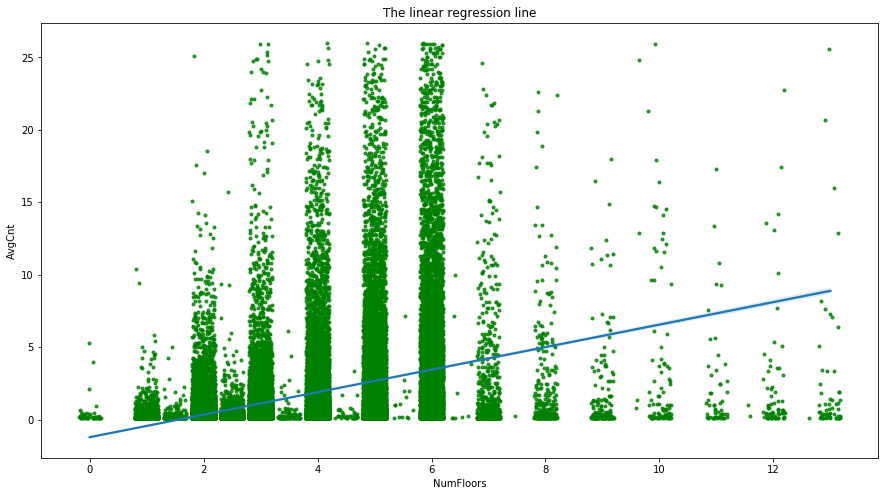

In [45]:
# Plot the regression plot of the total data
plt.figure(figsize=(15,8))
sns.regplot(x = 'NumFloors', y = 'AvgCnt', data = dhp_pluto_df,
            scatter_kws = {'color' : 'green'}, marker = ".", 
            x_jitter=.2, order = 1)
plt.title('The linear regression line')
plt.show()
plt.close()

On the other hand, a polynomial regression would be more likely to work better:

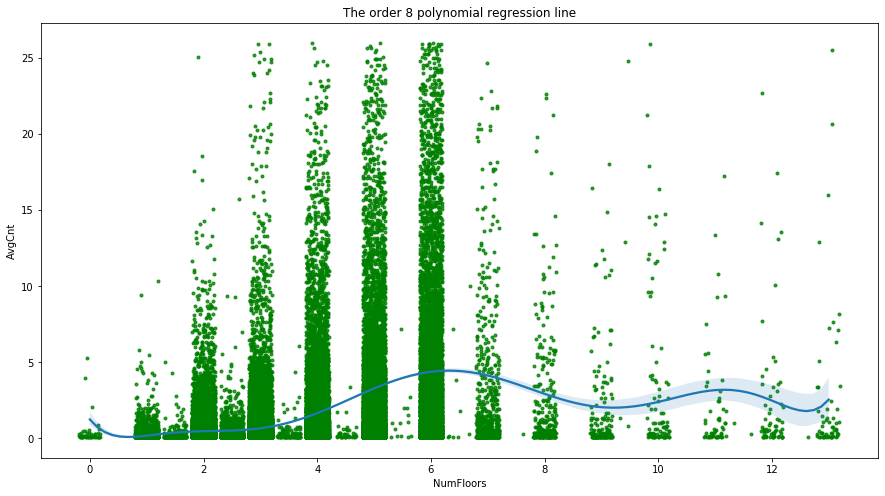

In [46]:
# Plot the regression plot of the total data
plt.figure(figsize=(15,8))
sns.regplot(x = 'NumFloors', y = 'AvgCnt', data = dhp_pluto_df,
            scatter_kws = {'color' : 'green'}, marker = ".", 
            x_jitter=.2, order = 8)
plt.title('The order 8 polynomial regression line')
plt.show()
plt.close()

## 3.3 Model type selection

As we have noticed, in the previous section, the data at hand does not exhibit simple linear dependency from the predictors. The dependency is at least polynomial. Therefore, polynomial regression is proposed to be used. For that matter proper polonomial digree is to be found by means of parameter tuning.

The feature correlation analysis has shown that there is a number of highly correlated predictors and thus the model can suffer from multicollinearity (independent variables are highly correlated). This will be mitigated by using Ridge regression. The latter parameters will also be tuned. 

Last but not least the parameter tuning will be done using the grid search approach with cross validation on the test set. In order to find the optimal set of features we shall use the Recursive feature elimination approach.

Further, before we proceed with model parameter tuning and feature set selection, let us split the data intp the training and validation sets with `30`% of observations used for testing.

In [47]:
# Scale the predictor (X) columns
X = dhp_pluto_df.loc[:, FEATURE_NAMES].values.astype(float)
print('Initial X Shape:', X.shape)

# Get the target (Y) column
y = dhp_pluto_df.loc[:, 'AvgCnt'].values.astype(float)
print('Initial y shape', y.shape )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print('Training: X shape:', X_train.shape, 'y shape:', y_train.shape)
print('Testing: X shape:', X_test.shape, 'y shape:', y_test.shape)

Initial X Shape: (74363, 17)
Initial y shape (74363,)
Training: X shape: (52054, 17) y shape: (52054,)
Testing: X shape: (22309, 17) y shape: (22309,)


## 3.4 Model tuning and feature selection

In this section we shall take he following approach:

1. For all features, use GridSearchCV to tune the pipe with:
    1. StandardScaler
    2. PolynomialFeatures
    3. Ridge
2. Use Recursive Feature Elimination (RFE) to choose the minimum set of features
3. Re-tune the pipeline again on the selected set of features

Please note that, here we use RFE in order to get he set of features providing the maximum $R^2$ score on the training set. The correlation matrix or the univariate feature analysis do not provide direct means to choose the minimum set of features providing the best predictability result. An alternative would be using the Principle Component Analysis (PCA) but this method requires feture space transformation which makes the resulting predictors to loose their physical meaning.

### 3.4.1 Initial model tuning

The initial model tuning will be done with the functions below, using all the features.

In [69]:
# Define the tuning parameter ranges
tune_degrees = [1, 2, 3]
tune_alphas = [5, 10, 15, 20, 25, 30]

In [70]:
def create_tuning_model(cv = 4, degrees = tune_degrees, alphas = tune_alphas) :
    '''Creates a grid search tuning pipeline model with standard
       scaler, polynomial fearutes and ridge regression'''
    
    # Create the list of tuples with the names 
    # mapped to instances of pipeline elements
    steps = [
             ('scale', StandardScaler())
             ,('poly', PolynomialFeatures())
             ,('ridge', Ridge())
             ]
    # Create the pipeline from the object
    pipe = Pipeline(steps)
    
    # Set the tuning parameter ranges
    params = { 'poly__degree' : degrees,
               'ridge__alpha' : alphas}
    
    # Instantiate the grid search with cross validation
    gs = GridSearchCV(pipe, params, cv = cv)
    
    return gs

In [71]:
def get_tuning_best_params(gs) :
    '''Allows to extract the best parameter
       values for the grid search model'''
    params = gs.best_estimator_.get_params()
    return (params['poly__degree'], params['ridge__alpha'])

In [72]:
# Perform the initial model tuning
tuning_model = create_tuning_model()

# Tune the model, here we use all features
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tuning_model.fit(X_train, y_train)

In [73]:
# Get the best parameter values
(best_degree, best_alpha) = get_tuning_best_params(tuning_model)

# Compute the R^2 score for the training set
best_train_score = tuning_model.best_estimator_.score(X_train, y_train)

print('Found best degree:', best_degree, ', alpha:', best_alpha, ', training R^2 score: ', best_train_score)

Found best degree: 2 , alpha: 15 , training R^2 score:  0.33792262258089545


The found best combination of parameters with the corresponding $R^2$ score is shown above. Remember that, the maximum  possible value of the $R^2$ is 1.0 and if the values are negative it means that the model is overfitting. As one can see from the tuning scores the polynomials of degree `>= 3` are overfitting:

In [74]:
# Report the positive scores, negative values mean over-fitting
scores = tuning_model.cv_results_
scores_df = pd.DataFrame(scores['params'])
scores_df['score'] = scores['mean_test_score']
scores_df = scores_df[scores_df['score'] >= 0]
display(scores_df)

,poly__degree,ridge__alpha,score
0,1,5,0.271733
1,1,10,0.271734
2,1,15,0.271735
3,1,20,0.271735
4,1,25,0.271735
5,1,30,0.271735
6,2,5,0.326965
7,2,10,0.326972
8,2,15,0.326975
9,2,20,0.326973


Let us also plot the alpha v.s. score values for the polynomial of the best found degree to see if this is indeed the best alpha value.

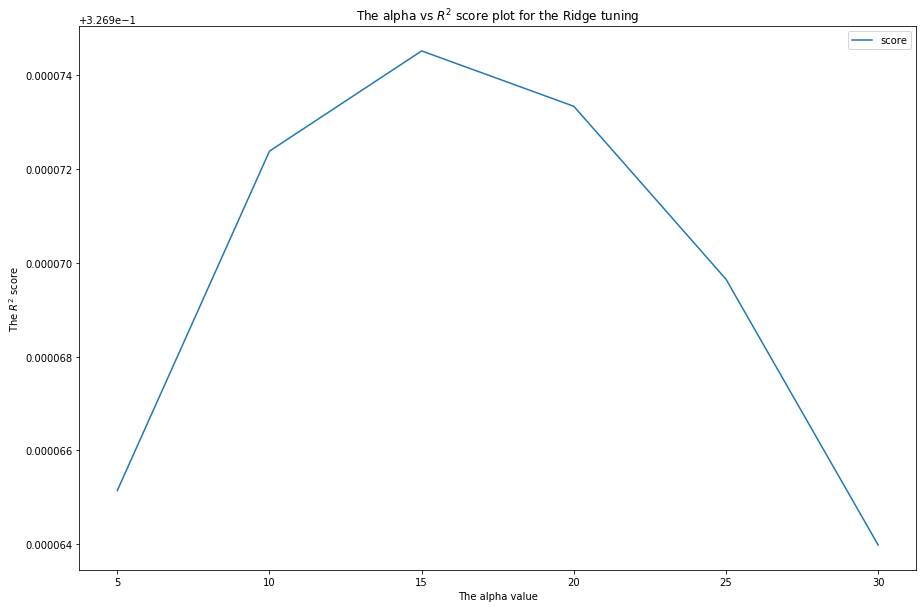

In [75]:
alpha_score_df = scores_df[scores_df['poly__degree'] == best_degree]
alpha_score_df.plot(kind = 'line', x = 'ridge__alpha', y = 'score', figsize=(15,10))
plt.title('The alpha vs $R^2$ score plot for the Ridge tuning')
plt.xlabel('The alpha value')
plt.ylabel('The $R^2$ score')
plt.show()
plt.close()

### 3.4.2 Recursive feature elimination

We shall begin by appying the basic RFE in order to plot the dependency between the number of features and the $R^2$ score. Pleas note that the number of polynomial features is larger than the number of the original ones. Also, because  RFE requires the features importance weights to be obtained either through the `coef_` or `feature_importances_` attributes we can not use pipelines here directly. Therefore, the scaler and the polynomial features are instantiated separately and the input pre-processing is done beforehand.

In [152]:
# Scale the inputs
std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train)

# Apply polynomial transform
poly_feat = PolynomialFeatures(degree = best_degree)
X_train_sc_pl = poly_feat.fit_transform(X_train_sc)

# Create the model
ridge_model = Ridge(alpha = best_alpha)

# Total number of features, note that we are in polynomials
nof_list = np.arange(1, poly_feat.n_output_features_+ 1)            
high_score=0

# Variable to store the optimum features
high_nof = 0
score_list = []
for n in range(len(nof_list)):
    # Create the RFE model for the given number of features
    #rfe_model = RFECV(estimator = ridge_model,
    #                  min_features_to_select = nof_list[n],
    #                  step = 1, cv = 4)
    rfe_model = RFE(ridge_model, nof_list[n])
    X_train_rfe = rfe_model.fit_transform(X_train_sc_pl, y_train)
    
    # Fit the model with the transformed set of parameters
    ridge_model.fit(X_train_rfe, y_train)

    # Compute the R^2 score on the training data
    score = ridge_model.score(X_train_rfe, y_train)
    
    # Manage the highest scores administration
    score_list.append(score)
    if(score > high_score):
        high_score = score
        high_nof = nof_list[n]

print("Optimum number of polynomial features: %d" %high_nof)
print("Score with %d polynomial features: %f" % (high_nof, high_score))

Optimum number of polynomial features: 163
Score with 163 polynomial features: 0.337923


The results above indicate the optimum number of polynomial features to be used and the corresponding $R^2$ score.

Let us also plot all the scores estimated by RFECV for different numbers of features:

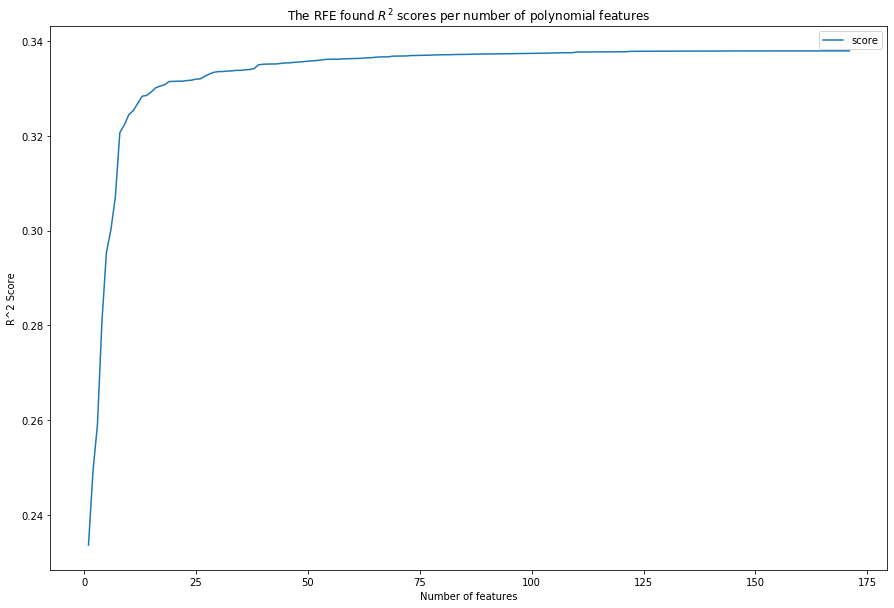

In [153]:
# Plot the scores per numner of features
scores_df = pd.DataFrame({'score' : score_list, 'num_features' : nof_list}) 
scores_df.plot(kind = 'line', x = 'num_features', y = 'score', figsize = (15, 10))
plt.title('The RFE found $R^2$ scores per number of polynomial features')
plt.xlabel('Number of features')
plt.ylabel('R^2 Score')
plt.show()
plt.close()

The plot above shows a rapid grow in the scores with increasing the number of features from `1` to about `20`. Then from `20` to about `75` the growth is slow, and is almost constant from 75 onwards. This experiment suggests that we should use `163` out of `171` features which is not very useful. Therefore, below let us consider the list of suggested RFECV polynomial features. RFECV uses cross validation and provides its own suggestion on the minimum number of features to be used:

In [161]:
def compute_rfecv_feature_set(est, min_nof = 1, step = 1, cv = 4):
    # Transforming data using RFE
    model = RFECV(estimator = est,
                  min_features_to_select = min_nof,
                  step = step, cv = cv)

    # Fitting the data to model
    model.fit(X_train_sc_pl, y_train)

    # Get the best set of features
    temp = pd.Series(model.support_, index = poly_feat.get_feature_names(FEATURE_NAMES))
    poly_top = temp[temp == True].index.to_list()

    return (model, poly_top)

# Compute the list of the RFE features to be used
(rfecv_model, rfecv_poly_top) = compute_rfecv_feature_set(ridge_model)

print('RFECV suggest using ', rfecv_model.support_.sum(),
      'polynomial features out of', poly_feat.n_output_features_)

RFECV suggest using  57 polynomial features out of 171


Notice that, RFECV suggests using roughly a third of the polynomial features, but how does this translate in to the original features?

In [162]:
def poly_to_origin_features(poly_top):
    # Convert from the polynomial features to the list of original feture names
    list_list_names = list(map(lambda x : str(x).replace('^2','').split(), poly_top))
    flatten = lambda l: [item for sublist in l for item in sublist]
    return list(set(flatten(list_list_names)))

# Transform the polynomial features into the unique original features list
rfecv_orig_top = poly_to_origin_features(rfecv_poly_top)

print('RFECV suggest using', len(rfecv_orig_top), 'original features are: ', rfecv_orig_top)

RFECV suggest using 16 original features are:  ['LotDepth', 'ResArea', 'FacilFAR', 'BldgDepth', 'BuiltFAR', 'YCoord', 'ResidFAR', 'LotArea', 'YearBuilt', 'YearAlter1', 'RetailArea', 'NumFloors', 'BldgArea', 'CommFAR', 'NumBldgs', 'XCoord']


Even though RFECV suggests using a third of the polynomial features this still translates into using all of the original `17` features.

### 3.4.3 Conusions on model/feature selection



# 4. Model evaluation

## 4.1 Pre-Evaluation on the training set

The RFECV model using `57` polynomial features has the training set $R^2$ score of:

In [164]:
rfecv_model.score(X_train_sc_pl, y_train)

0.3361864357435296

Which means that it explains only about `33.61`% of the variability of the response data around its mean. This seems as a not very high score.

However, let us consider the predictions on the training set, and e.g. count the number of negative (definitely a wrong prediction) values:

In [209]:
y_train_hat = rfecv_model.transform(X_train_sc_pl)
num_pred = len(y_train)
num_neg_pred = len(np.sum(np.array(y_train_hat < 0), axis = 0))
print('Non positive counts Y training set:', (y_train < 0).sum(), '/', num_pred,
      ', Y predicted set', num_neg_pred, '/', num_pred,
      '( i.e. about ', round(100*num_neg_pred/num_pred, 3), '%)')

Non positive counts Y training set: 0 / 52054 , Y predicted set 57 / 52054 ( i.e.  0.11 %)


So we have a very small number of definitely badly predicted - negative values. Let us also consider the differences in the distributions of the actual and predicted model values. Here we filter out the negative values:

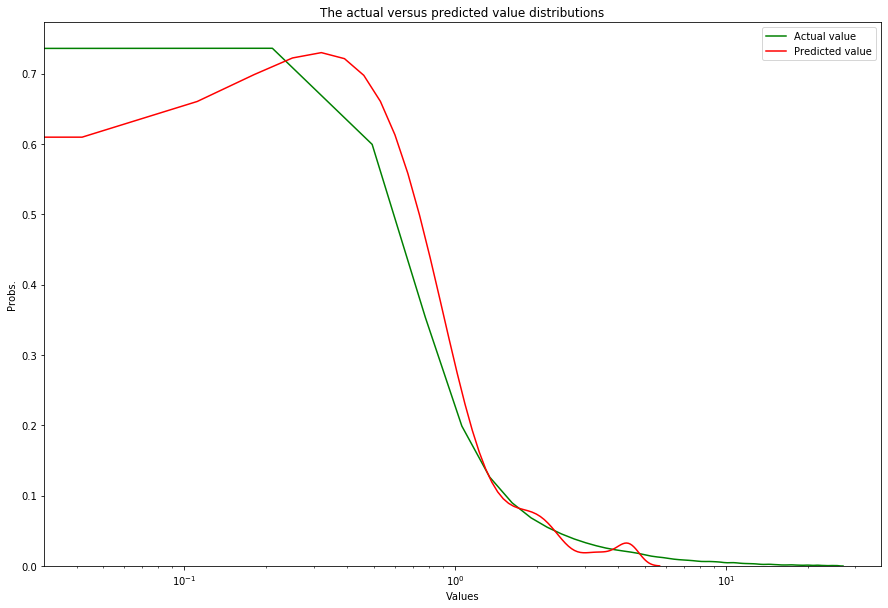

In [212]:
# Comparing the distribution plots of the actual and predicted values also allows to assess the quality of the model
def plot_distributions(Y, Yhat):
    plt.figure(figsize=(15,10))
    plt.title('The actual versus predicted value distributions')
    ax1 = sns.distplot(Y, hist = False, color = "green", label = "Actual value")
    ax2 = sns.distplot(Yhat, hist = False, color = "red", label = "Predicted value", ax = ax1)
    ax1.set_xscale('log')
    plt.ylabel('Probs.')
    plt.xlabel('Values')
    plt.show() 
    plt.close()

plot_distributions(y_train, np.select(y_train_hat >= 0, y_train_hat))

To conclcude, using the RFECV suggested number of polynomial features, we get a model that on the training set does have a rather low $R^2$ score. Yet, its produced output does seem to match the expected one in its distribution fairly weel. Still, we do suggest using the found polynomial features, but we do not suggest reducing the number of them any further. I.e. we also do not advise reducing the number of the original model features in order not to worsen the model accuracy. So we shall use all of the features to build the prediction model.

## 4.2 Evaluation on the test set

# 5. Conclusions

In [187]:
len(y_train_hat < 0)

52054